#  TP 4: 

### 14 avril 2024

### Par Samuel Fortin, Philippe Truchon et Benjamin Trudel

## TP4.1
Supposons, pour simplifier, que le corps humain est fait d'eau pure. Grâce à la base de données XCOM du NIST, trouvez le $\mu$ de l'eau pour des photons de 60 keV, à une masse volumique de 1.0g/$cm^3$. Quelle fraction du signal subsiste après avoir traversé 5cm d'eau; 20 cm d'eau?

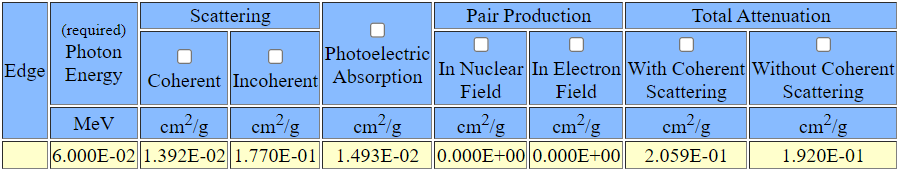

https://physics.nist.gov/PhysRefData/Xcom/html/xcom1.html

Avec la diffusion cohérente: $\mu = 0.2059$ $cm^2/g \cdot 1.0g/cm^3 = 0.2059 cm^{-1}$

Sans diffusion cohérente: $\mu = 0.1920$ $cm^2/g \cdot 1.0g/cm^3 = 0.1920 cm^{-1}$

On utilise donc la loi de Beer-Lambert : $I(x) = I_0 \cdot e^{-\mu \cdot x}$

Pour 5 cm: $I(5) = I_0 \cdot e^{-0.2059 \cdot 5} = 0.3577 I_0$

Pour 20 cm: $I(20) = I_0 \cdot e^{-0.2059 \cdot 20} = 0.0165 I_0$

## TP4.2
En utilisant le code fourni (ou pas), créer une rétroprojection simple, aussi appelée laminogramme, des données de projection fournies. Notez qu'une approche par slicing pourrait accélérer votre algorithme. Votre code utilisera la méthode du plus proche voisn pour déterminer la valeur de projection à utiliser (le rayon passant par la source et le voxel d'intérêt n'aboutit pas nécessairement au centre des pixels du détecteur). Une fois que vous aurez accès au fantôme numérique, comparez-le à la reconstruction. Qualitativement, quelles différebces observez-vous entre l'image reconstruite et l'image de référence (fantôme)?

## TP4.3
En utilisant la librairie numpy.fft, implémentez le filtre passe-haut proposé pour filtrer le sinogramme une projection à la fois. Affichez et sauvegardez l'image du sinogramme filtré. Qualitativement, quelles sont les principales différences entre le sinogramme fourni et filtré?

## TP4.4
Ayant en main le sinogramme filtré, effectuez une rétroprojection filtrée, en récupérant idéalement le code précédent du laminogramme. Comparez l'image obtenue avec le fantôme. Quelles différences observez-vous? Où sont situées les erreurs et que diriez-vous de la fréquence spatiale des erreurs?

## TP4.5
Écrivez une nouvelle fonction de reconstruction reconFourierSlice() qui effectue la reconstruction via le théorème de la tranche de Fourier. Il faut effectuer la TF 1D de chaque projection du sinogramme et stocker le nouveau sinogramme transformé. Par échantillonnage du sinogramme, remplissez l'espace de Fourier 2D de l'image à reconstruire. Vous pouvez choisir l'angle approprié par la méthode du plus proche voisin et la position sur le détecteur par interpolation linéaire. Trouvez l'image par $TF_{2D}^{-1}$ et commentez les résultats. Indice : considérez toutes les données comme des nombres complexes avec l'initialisation suivante mymatrix = numpy.zeros((a,b),"complex"), puis, prenez la partie réelle de l'image finale.